# Predicting house prices with linear models

In this project, you will work with the Ames house data set which we already encountered in the lectures. Your task is to evaluate the following four linear models in terms of their performance when predicting house prices:

1. Linear regression
2. Ridge regression
3. Lasso
4. Elastic net

*General hints:*

1. Clearly label all graphs (axes, title, legend if required).
2. When asked to provide a specific answer (e.g., "Report the number of non-zero coefficients...") make sure the answer is clearly printed in the notebook.
3. Whenever a computation involves random number generation, initialise the seed to `123` to get reproducible results. Specifically, for `scikit-learn` functions this requires passing `random_state=123` where applicable.

In [64]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Data description

The data is stored in `data/ames_houses.csv` in the course [GitHub repository](https://github.com/richardfoltyn/MLFP-ECON5130) and can be downloaded using the link
[https://raw.githubusercontent.com/richardfoltyn/MLFP-ECON5130/main/data/ames_houses.csv](https://raw.githubusercontent.com/richardfoltyn/MLFP-ECON5130/main/data/ames_houses.csv).

To load the data, you need to specify the file path depending on your computing environment:

In [2]:
# Use this path if you want to download the file directly from Github
file = 'https://raw.githubusercontent.com/richardfoltyn/MLFP-ECON5130/main/exercises/ames_houses.csv'

In [3]:
data = pd.read_csv(file)

In [4]:
data.head()

,SalePrice,LotArea,Neighborhood,BuildingType,OverallQuality,OverallCondition,YearBuilt,CentralAir,LivingArea,Bathrooms,Bedrooms,Fireplaces,HasGarage
0,208500.0,784.954075,CollgCr,Single-family,7,5,2003,Y,158.848694,2,3,0,1
1,181500.0,891.782144,Veenker,Single-family,6,8,1976,Y,117.232194,2,3,1,1
2,223500.0,1045.057200,CollgCr,Single-family,7,5,2001,Y,165.908636,2,3,1,1
3,140000.0,887.137445,Crawfor,Single-family,7,5,1915,Y,159.498952,1,3,1,1
4,250000.0,1324.668060,NoRidge,Single-family,8,5,2000,Y,204.180953,2,4,1,1


You can load the CSV file as a `pandas` `DataFrame` as follows:

In [5]:
data.describe()

,SalePrice,LotArea,OverallQuality,OverallCondition,YearBuilt,LivingArea,Bathrooms,Bedrooms,Fireplaces,HasGarage
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.0
mean,180921.195890,976.949947,6.099315,5.575342,1971.267808,140.777444,1.565068,2.866438,0.613014,1.0
std,79442.502883,927.199358,1.382997,1.112799,30.202904,48.813961,0.550916,0.815778,0.644666,0.0
min,34900.000000,120.762165,1.000000,1.000000,1872.000000,31.026587,0.000000,0.000000,0.000000,1.0
25%,129975.000000,701.674628,5.000000,5.000000,1954.000000,104.923743,1.000000,2.000000,0.000000,1.0
50%,163000.000000,880.495526,6.000000,5.000000,1973.000000,135.996777,2.000000,3.000000,1.000000,1.0
75%,214000.000000,1077.709432,7.000000,6.000000,2000.000000,165.049367,2.000000,3.000000,1.000000,1.0
max,755000.000000,19994.963289,10.000000,9.000000,2010.000000,524.107798,3.000000,8.000000,3.000000,1.0


The included variables are a simplified subset of the data available at [openml.org](https://www.openml.org/d/42165):

- `SalePrice`: House price in US dollars (float)
- `LotArea`: Size of the lot in m² (float)
- `Neighborhood`: Name of the neighborhood (string)
- `BuildingType`: Type of building (categorical stored as string)
- `OverallQuality`: Rates the overall condition of the house from (1) "very poor" to (10) "excellent" (integer)
- `OverallCondition`: Rates the overall material and finish of the house from (1) "very poor" to (10) "excellent" (integer)
- `YearBuilt`: Original construction date (integer)
- `CentralAir`: Central air conditioning: Yes/No (categorical string)
- `LivingArea`: Above-ground living area in m² (float)
- `Bathrooms`: Number of bathrooms (integer)
- `Bedrooms`: Number of bedrooms (integer)
- `Fireplaces`: Number of fireplaces (integer)
- `HasGarage`: Indicator whether house has a garage (integer)

# Data preprocessing

Apply the following steps to preprocess the data before estimation:

1. Drop all rows which contain any missing values (`NaN`)

    *Hint:* Use [`dropna()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html)
    to remove rows with missing observations.
    
2. Trim outliers:
    1. Compute the 1st and 99th percentiles of the variables 
        `SalePrice`, `LivingArea` and `LotArea`
    2. Drop all observations in which any of these variables is below its
        1st percentile or above its 99th percentile.

    *Hint:* Use [`quantile()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.quantile.html)
    to compute the percentiles for the relevant variables. To convert percentiles to quantiles,
    you need to divide by 100.

3. Recode the string values in column `CentralAir` into numbers such that 
    `'N'` is mapped to 0 and `'Y'` is mapped to 1. Store this numerical variable
    using the column name `HasCentralAir`.
4. Recode the values in column `Fireplaces` and create the new variable `HasFireplace`
    so that `HasFireplace = 1` whenever at least one fireplace is present and 
    `HasFireplace = 0` otherwise.
5. Recode the string values in column `BuildingType` and create the new variable
    `IsSingleFamily` which takes on the value 1 whenever a house is a 
    single-family home and 0 otherwise.
6. Plot the kernel densities (or histograms) for the variables `SalePrice`, `LivingArea` and `LotArea`.
    You will notice that all three variables have a 
    [right-skewed](https://en.wikipedia.org/wiki/Skewness) distribution.
    
    *Hint:* You can plot kernel densities using 
    [`DataFrame.plot.kde()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.kde.html)
    and histograms with 
    [`DataFrame.plot.hist()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.hist.html)
7. Convert the variables `SalePrice`, `LivingArea` and `LotArea` to (natural) logs and re-create
    the kernel density or histogram plots for the logged variables.
    Name the transformed columns `logSalePrice`, `logLivingArea` and `logLotArea`.

### 1. Dropping all the null values

In [6]:
data.isnull().sum()

SalePrice            0
LotArea              0
Neighborhood         0
BuildingType        74
OverallQuality       0
OverallCondition     0
YearBuilt            0
CentralAir           0
LivingArea           0
Bathrooms            0
Bedrooms             0
Fireplaces           0
HasGarage            0
dtype: int64

In [7]:
data.dropna(inplace = True)

### 2. Trimming the outliers

In [8]:
def trim_outliers(df, **kwargs):
    """Trims outliers of the dataframe
    kwargs: The column names for which the outliers are to be dropped.
    df: The main dataframe
    """
    for column in kwargs.values():
        df = df[(df[column] > df[column].quantile(0.01)) &
                (df[column] < df[column].quantile(0.99))
               ]
    return df
    
    

In [9]:
data_new = trim_outliers(data, 
                         column_1 = "SalePrice", 
                         column_2 = "LivingArea", 
                         column_3 = "LotArea")

### 3. Encoding the data

In [10]:
data_new["HasCentralAir"] = data_new["CentralAir"].apply(lambda x: 1 if x == "Y" else 0)
data_new["HasFirePlace"] = data_new["Fireplaces"].apply(lambda x: 1 if x == "Y" else 0)
data_new["IsSingleFamily"] = data_new["BuildingType"].apply(lambda x: 1 if x == "Single-family" else 0)

In [11]:
data_new.head()

,SalePrice,LotArea,Neighborhood,BuildingType,OverallQuality,OverallCondition,YearBuilt,CentralAir,LivingArea,Bathrooms,Bedrooms,Fireplaces,HasGarage,HasCentralAir,HasFirePlace,IsSingleFamily
0,208500.0,784.954075,CollgCr,Single-family,7,5,2003,Y,158.848694,2,3,0,1,1,0,1
1,181500.0,891.782144,Veenker,Single-family,6,8,1976,Y,117.232194,2,3,1,1,1,0,1
2,223500.0,1045.057200,CollgCr,Single-family,7,5,2001,Y,165.908636,2,3,1,1,1,0,1
3,140000.0,887.137445,Crawfor,Single-family,7,5,1915,Y,159.498952,1,3,1,1,1,0,1
4,250000.0,1324.668060,NoRidge,Single-family,8,5,2000,Y,204.180953,2,4,1,1,1,0,1


### 4. Plotting histograms for `SalePrice `, `LotArea`, and `LivingArea`

In [12]:
import scipy.stats as sp

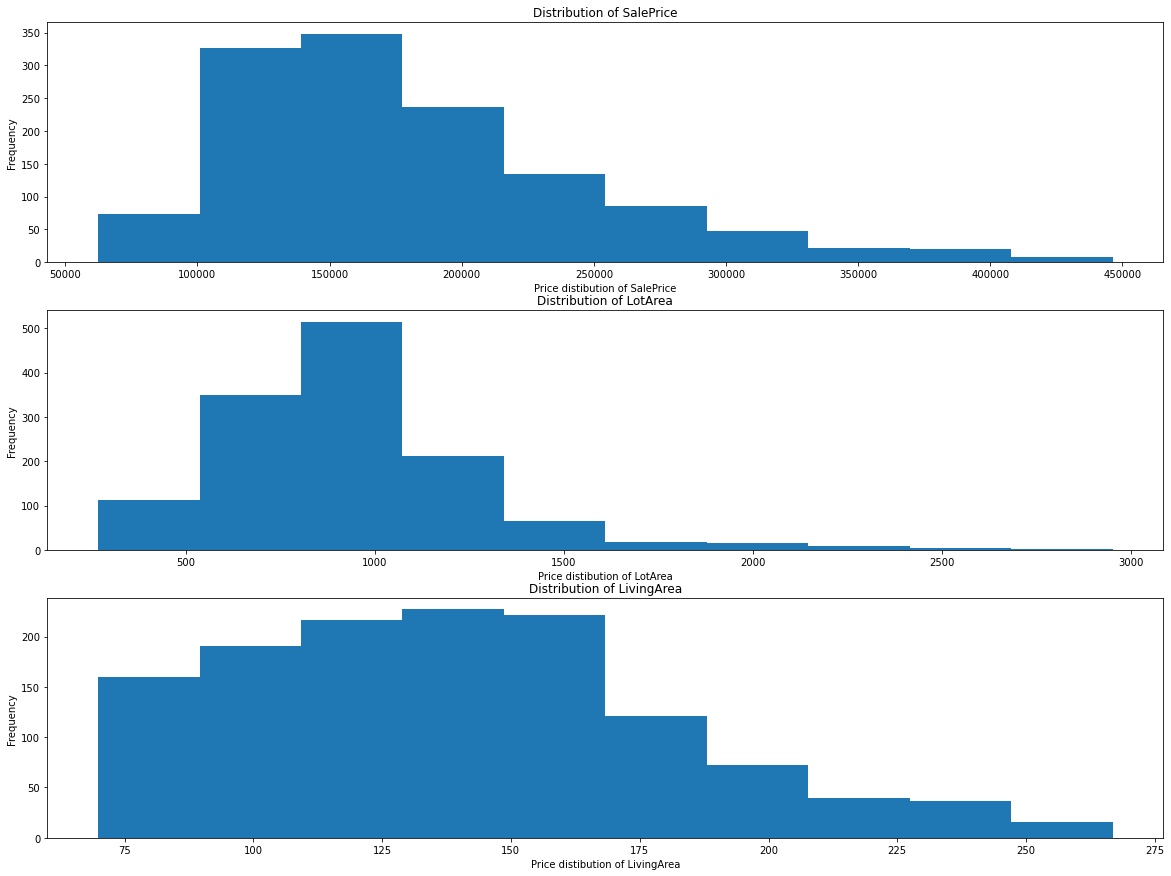

In [13]:
requried_rows = ["SalePrice", "LotArea", "LivingArea"]
fig, ax = plt.subplots(3, figsize = (20, 15))
for idx, row in enumerate(requried_rows):
    ax[idx].hist(data_new[row])
    ax[idx].set_xlabel(f"Price distibution of {row}")
    ax[idx].set_ylabel("Frequency")
    ax[idx].set_title(f"Distribution of {row}")

### 4. Logarithm tranformation of the columns  `SalePrice `, `LotArea`, and `LivingArea`

In [14]:
data_new["LogSalePrice"] = data_new["SalePrice"].apply(lambda x: np.log(x))
data_new["LogLotArea"] = data_new["LotArea"].apply(lambda x: np.log(x)) 
data_new["LogLivingArea"] = data_new["LivingArea"].apply(lambda x: np.log(x))

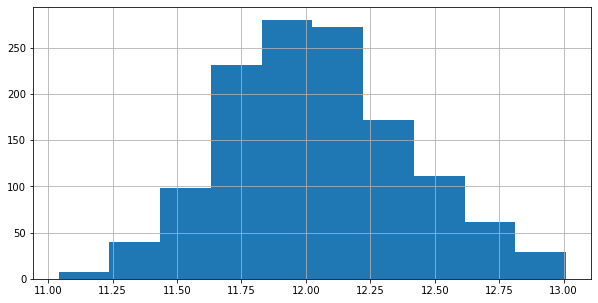

In [22]:
data_new["LogSalePrice"].hist(figsize = (10, 5))

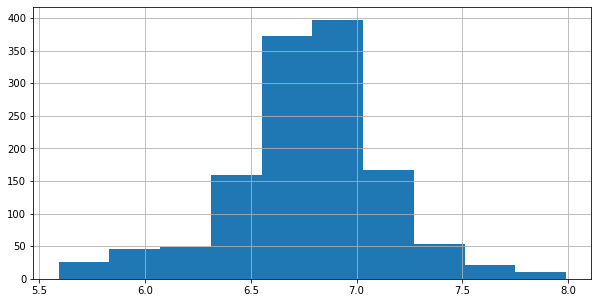

In [23]:
data_new["LogLotArea"].hist(figsize = (10, 5))

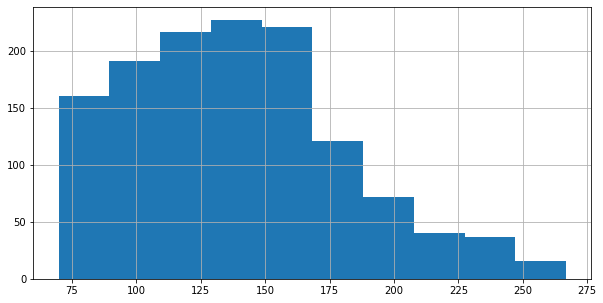

In [25]:
data_new["LivingArea"].hist(figsize = (10, 5))

# Estimation

## Model specification

You are now asked to estimate the following model of house prices
as a function of house characteristics:
$$
\begin{aligned}
\log(SalePrice_i) 
    &= \alpha + f\Bigl(\log(LivingArea_i), ~
        \log(LotArea_i), ~OverallCondition_i, \\
    & \qquad \qquad \qquad  OverallQuality_i,~ 
    Bathrooms_i,~ Bedrooms_i\Bigr) \\
    &+ \gamma_0 YearBuilt_i + 
    \gamma_1 HasCentralAir_i + 
    \gamma_2 HasFireplace_i + 
    \gamma_3 IsSingleFamily_i + 
    \epsilon_i
\end{aligned}
$$
where $i$ indexes observations and $\epsilon$ is an additive error term.
The function $f(\bullet)$ is a *polynomial of degree 3* in its
arguments, i.e., it includes all terms and interactions of the given variables
where the exponents sum to 3 or less:
$$
\begin{aligned}
f(\log(LivingArea_i), \log(LotArea_i), \dots)
    &= \beta_0 \log(LivingArea_i) 
    + \beta_1 \log(LivingArea_i)^2 \\
    &+ \beta_2 \log(LivingArea_i)^3 
    + \beta_3 \log(LotArea_i) \\
    &+ \beta_4 \log(LotArea_i)^2
    + \beta_5 \log(LotArea_i)^3 \\
    &+ \beta_6 \log(LivingArea_i)\log(LotArea_i) \\
    &+ \beta_7 \log(LivingArea_i)^2 \log(LotArea_i) \\
    &+ \beta_8 \log(LivingArea_i) \log(LotArea_i)^2 \\
    &+ \cdots 
\end{aligned}
$$

Create a feature matrix `X` which contains all polynomial interactions as well as the remaining non-interacted variables.

*Hints:* 

- Use the 
[`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)
transformation to create the polynomial terms and interactions from the columns
    `logLivingArea`, `logLotArea`, 
    `OverallCondition`, `OverallQuality`, 
    `Bathrooms` and  `Bedrooms`.
- Make sure that the generated polynomial does *not* contain a 
constant ("bias"). You should include the intercept when estimating a model instead.
- You can use [`np.hstack()`](https://numpy.org/doc/stable/reference/generated/numpy.hstack.html) to concatenate two matrices (the polynomials and the remaining covariates) along the column dimension.
- The complete feature matrix `X` should contain a total of 87 columns.

In [26]:
from sklearn.preprocessing import PolynomialFeatures

In [36]:
poly = PolynomialFeatures(3, include_bias=False)

In [37]:
X = poly.fit_transform(data_new[["LogLivingArea", "LogLotArea", "OverallCondition", "OverallQuality", "Bathrooms", "Bedrooms"]])

In [42]:
X = np.hstack((X, data_new[['YearBuilt', 'HasCentralAir', 'HasFirePlace', 'IsSingleFamily']]))

In [43]:
X

array([[5.06795214, 6.66562521, 5.        , ..., 1.        , 0.        ,
        1.        ],
       [4.76415654, 6.79322187, 8.        , ..., 1.        , 0.        ,
        1.        ],
       [5.11143725, 6.9518269 , 5.        , ..., 1.        , 0.        ,
        1.        ],
       ...,
       [5.3816097 , 6.73333916, 9.        , ..., 1.        , 0.        ,
        1.        ],
       [4.60656624, 6.8053357 , 6.        , ..., 1.        , 0.        ,
        1.        ],
       [4.75939084, 6.82772394, 6.        , ..., 1.        , 0.        ,
        1.        ]])

In [45]:
y = np.log(data_new.SalePrice)

## Train-test sample split

Split the data into a training and a test subset such that the training
sample contains 70% of observations.

*Hint:* 

- Use the function [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the sample.
    Pass the argument `random_state=123` to get reproducible results.
- Make sure to define the training and test samples only *once* so that they are identical for all estimators used below. 

In [44]:
from sklearn.model_selection import train_test_split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)

## Linear regression

Perform the following tasks:

1. Comment on whether you need to standardise features before estimating a linear regression model. Does the linear regression model have any hyperparameters?
2. Estimate the above model specification using a linear regression model on the training sub-set. 
3. Compute and report the mean squared error (MSE) on the test sample.
4. Plot the prediction errors (on the $y$-axis) against the outcome variable on the test sample.

*Hints:*

- Use the [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) class to estimate the model.
- The mean squared error can be computed with [`mean_squared_error()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html).

In [52]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression


In [48]:
lin_reg = LinearRegression(fit_intercept=True)

In [49]:
lin_reg.fit(X_train, y_train)

LinearRegression()

In [51]:
y_pred = lin_reg.predict(X_test)

In [53]:
error = mean_squared_error(y_test, y_pred)

In [54]:
rmse = np.sqrt(error)

In [55]:
r2 = r2_score(y_test, y_pred)

In [57]:
print(f"The r2 score of the model is {r2:.4f} with a MSE of {error:.4f} and RMSE of {rmse:.4f}")

The r2 score of the model is 0.8190 with a MSE of 0.0230 and RMSE of 0.1517


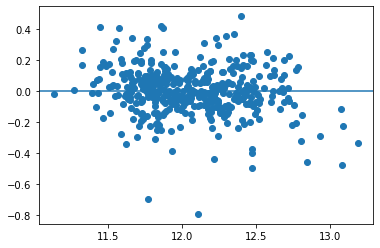

In [70]:
plt.scatter(y_pred,
           (y_test - y_pred)
           )
plt.axhline(0.0)

## Ridge regression

Perform the following tasks:

1. Does Ridge regression require feature standardisation? If so, don't forget to apply it before fitting the model.
2. Use [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)
    to determine the best regularisation strength $\alpha$ on the training sub-sample.
    You can use the MSE metric (the default) to find the optimal $\alpha$.
    Report the optimal $\alpha$ and the corresponding MSE.
3. Plot the MSE (averaged over folds on the training sub-sample) against the regularisation strength $\alpha$ on the $x$-axis (use a log scale for the $x$-axis).
4. Compute and report the MSE on the test sample.
5. Plot the prediction errors (on the $y$-axis) against the outcome variable on the test sample.

*Hints:* 

- Determine a suitable range for the grid of candidate $\alpha$ and space them uniformly in logs. 
- Recall that the (negative!) best MSE is stored in the attribute `best_score_` after cross-validation is complete.

In [58]:
from sklearn.linear_model import RidgeCV

In [74]:
alphas = np.linspace(0.1, 10, 100)

In [75]:
ridge = RidgeCV(alphas=alphas)

In [76]:
ridge.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
        6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
        7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
        8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
       10. ]))

In [78]:
y_pred_ridge = ridge.predict(X_test)

In [84]:
r2_ridge = r2_score(y_test, y_pred_ridge)

In [80]:
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

In [82]:
rmse_ridge = np.sqrt(mse_ridge)

In [85]:
print(f"The r2 score of the ridge model is {r2_ridge:.4f} with a MSE of {mse_ridge:.4f} and RMSE of {rmse_ridge:.4f}")

The r2 score of the ridge model is 0.8487 with a MSE of 0.0192 and RMSE of 0.1387


## Lasso

Perform the following tasks:

1. Does Lasso require feature standardisation? If so, don't forget to apply it before fitting the model.
2. Use [`LassoCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html)
    to determine the best regularisation strength $\alpha$ on the training sub-sample
    using cross-validation with 5 folds.
    You can use the MSE metric (the default) to find the optimal $\alpha$.
    Report the optimal $\alpha$ and the corresponding MSE.
3. Plot the MSE (averaged over folds on the training sub-sample) against the regularisation strength $\alpha$ on the $x$-axis (use a log scale for the $x$-axis).
4. Compute and report the MSE on the test sample for the model using the optimal $\alpha$.
5. Report the number of non-zero coefficients for the model using the optimal $\alpha$.
6. Plot the prediction errors (on the $y$-axis) against the outcome variable on the test sample.

*Hints:* 

- Getting Lasso to converge may require some experimentation. The following settings should help: increase the max. number of iterations to `max_iter=100000` and use `selection='random'`. Set `random_state=123` to get reproducible results:

    ```python
    LassoCV(..., max_iter=100000, selection='random', random_state=123)
    ```

- After cross-validation is complete, the MSE for each value of $\alpha$ and each fold are stored in the attribute `mse_path_` which is an array with shape `(N_ALPHA, N_FOLDS)`.

In [86]:
from sklearn.linear_model import LassoCV

In [87]:
lasso = LassoCV(alphas=alphas, max_iter = 100000, selection="random", random_state=123)

In [88]:
lasso.fit(X_train, y_train)

LassoCV(alphas=array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
        6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
        7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
        8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
       10. ]),
        max_iter=100000, random_state=123, selection='random')

In [89]:
y_pred_lasso = lasso.predict(X_test)

In [90]:
mean_squared_error(y_test, y_pred_lasso)

0.01745144677359223

In [91]:
r2_score(y_test, y_pred_lasso)

0.8627841068651054

In [92]:
lasso.alpha_

0.1

## Elastic net

The elastic net is a linear model that applies both L1 and L2 regularisation, i.e., it's a generalisation of Ridge regression and Lasso. Its loss function is given by
$$
L(\mu, \mathbf{\beta}) = \frac{1}{2N}
    \underbrace{\sum_{i=1}^N \Bigl(
    y_i - \mu - \mathbf{x}_i'\mathbf{\beta}\Bigr)^2}_{\text{Sum of squared errors}}
    + 
    \underbrace{\alpha \rho \sum_{k=1}^K |\beta_k|}_{\text{L1 penalty}}    
    + 
    \underbrace{\alpha (1-\rho) \sum_{k=1}^K\beta_k^2}_{\text{L2 penalty}}
$$
The additional parameter $\rho$ is called the L1 ratio and determines the relative weight of the L1 vs L2 penalty terms (see also the `scikit-learn` 
[user guide](https://scikit-learn.org/stable/modules/linear_model.html#elastic-net)).
Compared to Ridge regression and Lasso, this model therefore includes two hyperparameters, $\alpha$ and $\rho$, both of which should be determined using cross-validation.
It is easy to see that for the corner case of $\rho = 1$, the elastic net corresponds to the Lasso, while for $\rho = 0$ is corresponds to Ridge regression.

Perform the following tasks:

1. Does the elastic net require feature standardisation?
2. Use [`ElasticNetCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html)
    to determine the best regularisation strength $\alpha$ and L1 ratio $\rho$ on the training sub-sample
    using cross-validation with 5 folds.
    You can use the MSE metric (the default) to find the optimal hyperparameter values.
    Report the optimal $\alpha$ and $\rho$ and the corresponding MSE.
3. Compute and report the MSE on the test sample for the model with optimal hyperparameters.
4. Report the number of non-zero coefficients for the model with optimal hyperparameters.
5. Plot the prediction errors (on the $y$-axis) against the outcome variable on the test sample.

*Hints:* 

- Getting elastic net to converge may require some experimentation. The following settings should help: increase the max. number of iterations to `max_iter=100000` and use `selection='random'`. Set `random_state=123` to get reproducible results. 

    ```python
    ElasticNetCV(..., max_iter=100000, selection='random', random_state=123)
    ```

- The grid for $\alpha$ is determined in the same way as for `LassoCV`. For $\rho$, use the argument `l1_ratio` to pass a grid of candidate L1 rations given by `[0.1, 0.5, 0.7, 0.9, 0.95, 0.99]`:

    ```python
    ElasticNetCV(..., l1_ratios=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99], ...)
    ```

- Use [`ElasticNet`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) to estimate the elastic net once you identified the optimal hyperparameters.
    Make sure to pass the same values for `max_iter`, `selection` and `random_state` as you did earlier.

## Compare estimation results

Create a table which contains the MSE computed on the test sample for all four models (using their optimal hyperparameters). Which model yields the lowest MSE? Comment on why you think this is the case.